# Semantic Image Search -- Overview

## 2 Approach

How are we going to achieve this? We're going to map (or "embed") both textual captions and images to a common "semantic" space. Let's assume this semantic space has dimension 50. Let

&nbsp;&nbsp;&nbsp;&nbsp; `se_text()` be a function that maps a piece of text to its semantic embedding, and

&nbsp;&nbsp;&nbsp;&nbsp; `se_image()` be a function that maps an image to its semantic embedding.

We want these mappings to have the property that a caption and image with similar meanings will map to semantic embeddings that are near each other in the semantic space. (This concept should sound familiar from our earlier work with word embeddings...) For example, we would like `se_text('pizza')` to be close to `se_image(pizza_slice_img)`. 

We'll use cosine similarity to measure the similarity between two vectors: 

\begin{equation}
\text{sim}(\vec{x}, \vec{y}) = \cos{\theta} = \frac{\vec{x} \cdot \vec{y}}{\lVert \vec{x} \rVert \lVert \vec{y} \rVert}
\end{equation}

where $\lVert \vec{x} \rVert = \sqrt{x_0^2 + x_1^2 + ...}$ is the magnitude of $\vec{x}$ and $\vec{x} \cdot \vec{y}$ is the *dot product* of the two vectors. Note that if both vectors are already normalized to have unit length, then cosine similarity is equivalent to the dot product between the two vectors.

Once we have `se_text()` and `se_image()`, we can build our image search system:
- **Preprocessing**: Create an image database by running a collection of images through `se_image()` and saving their semantic embeddings.
- **Search by text**: To process a text query, compute the cosine similarity between the semantic embedding of the query, `se_text(query)`, with all the semantic embeddings in the image database and return the ones with the highest scores.

## 3 Text Embedding

We'll embed text by essentially averaging the word embeddings (e.g., GloVe embeddings of dimension 50) for all words in the string.

We'll weight each word by the inverse document frequency (IDF) of the word (computed across all captions in the training data) in order to down-weight common words.

We'll also normalize the weighted sum to have unit length so that similarities can be computed with the dot product.

Note that there are no trainable parameters here. You can load in the GloVe embeddings as follows: 

In [1]:
from cogworks_data.language import get_data_path
import numpy as np
from pathlib import Path
import json
from collections import Counter

# load COCO metadata
filename = get_data_path("captions_train2014.json")
with Path(filename).open() as f:
    coco_data = json.load(f)

In [2]:
import re, string
punc_regex = re.compile('[{}]'.format(re.escape(string.punctuation)))
from gensim.models import KeyedVectors
filename = "glove.6B.200d.txt.w2v"

# this takes a while to load -- keep this in mind when designing your capstone project
glove = KeyedVectors.load_word2vec_format(get_data_path(filename), binary=False)
    

In [3]:
def preprocess_captions(captions):
    words = []
    for caption in captions:
        cleaned_caption = punc_regex.sub('', caption).lower()
        words2 = cleaned_caption.split()
        words.extend(words2)

    word_counts = Counter(words)
    num_docs = len(captions)
    weights = {word: np.log10(num_docs / count) for word, count in word_counts.items()}
    return weights

In [4]:
all_captions = [caption_info["caption"] for caption_info in coco_data["annotations"]]
ids = [caption_info["image_id"] for caption_info in coco_data["annotations"]]
idf_weights = preprocess_captions(all_captions)
#print(all_captions[0])
#print(idf_weights.keys())
#print(all_captions)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [5]:
def embed_caption(caption, dim=200):
    
    cleanCap = punc_regex.sub('', caption).lower()
    tokens = cleanCap.split()

    real_embeddings = []
    for word in tokens:
        if word in glove:
            idf = idf_weights.get(word)
            #print(word)
            #print(idf)
            #print(glove[word].dtype)
            real_embeddings.append(idf * glove[word])  # Directly calculate weighted embedding
        else:
            real_embeddings.append(np.zeros(dim))  # Zero vector for missing words
    if not real_embeddings:  #No words
        return np.zeros(dim)
    
    # Sum
    caption_embedding = np.sum(real_embeddings, axis=0) 
    normalized_embedding = caption_embedding / np.linalg.norm(caption_embedding)  # Normalize
    return normalized_embedding

all_embeddings = [embed_caption(caption) for caption in all_captions]

final_embeddings = {}

for i in np.arange(len(all_embeddings)):
    final_embeddings[ids[i]] = all_embeddings[i]



In [6]:
#print(final_embeddings.keys())
print(final_embeddings.get(318556))


[ 0.03502823  0.03479497  0.03211159 -0.03339696  0.1027096   0.06435473
 -0.03869871 -0.04064494 -0.02298549 -0.0550265   0.00939637  0.05409231
  0.02444795 -0.01197119  0.04067527 -0.02895387  0.00083085  0.03044537
  0.05255633  0.01671068  0.04710143  0.4290766   0.10024495 -0.12816665
  0.09469597 -0.08372366 -0.06372536  0.00678471 -0.02583823 -0.06804042
 -0.00204211 -0.06015849  0.09361167  0.07911514 -0.05967597 -0.03350711
 -0.0703767  -0.02426785  0.05670422 -0.03290254  0.00881939  0.02075326
 -0.04133103  0.07012354  0.06131923  0.04794552  0.13841508 -0.06638858
  0.01677139  0.0974602  -0.01087038  0.09372333  0.0228925   0.01504813
 -0.01384328  0.05764385 -0.06148203 -0.00846791  0.00788408 -0.0237606
 -0.09038465  0.04825925  0.04963616  0.03662503  0.01771591 -0.02508988
 -0.05405008 -0.17154288 -0.02333882 -0.05054311  0.10139082  0.05519302
 -0.01997058  0.03295426 -0.0265367   0.01306409 -0.07645915 -0.04956068
 -0.0784054  -0.028864   -0.01282338 -0.07368346  0.

## 4 Image Embedding
### 4.1 Image Features

To bootstrap our image embedding capability, we're going to make use of a pre-trained computer vision model that was trained to do image classification on the ImageNet dataset. (For more info on ImageNet, see: http://www.image-net.org/).

In particular, we're going to use the ResNet-18 model (implemented in PyTorch). ResNet-18 is a type of convolutional neural network (CNN). The last layer of ResNet-18 is a fully connected layer ("dense" layer in MyNN terminology; "Linear" layer in PyTorch terminology) that projects the final 512-dimensional "abstract features" to 1000-dimensional scores used for computing probabilities that an input image is one of the 1000 possible ImageNet classes. We're going to use these 512-dimensional abstract features (which have distilled useful properties/characteristics/aspects of the image) as a starting point for our image embedder.

You can imagine that we have a function called `extract_features_resnet18(image)` that takes an image (e.g., in PIL format), runs it through the ResNet-18 model, and then returns a NumPy array of shape (1, 512). You don't have to write this function yourself, though! We've already pre-extracted these 512-dimensional image features for images in the COCO dataset (described below).

The file `resnet18_features.pkl` contains a dictionary that maps image ids (from the COCO dataset) to extracted image features, imported below: 

In [7]:
# Load saved image descriptor vectors
import pickle
from cogworks_data.language import get_data_path

from pathlib import Path

with Path(get_data_path('resnet18_features.pkl')).open('rb') as f:
    resnet18_features = pickle.load(f)

print(resnet18_features.keys())


dict_keys([57870, 384029, 222016, 520950, 69675, 547471, 122688, 392136, 398494, 90570, 504616, 161919, 457732, 44404, 4428, 170558, 405613, 283524, 37015, 71631, 491269, 365363, 64460, 581674, 470072, 344806, 84427, 317237, 409382, 570608, 469605, 356702, 405207, 472925, 214704, 279108, 438422, 257350, 393493, 62426, 19380, 485894, 446014, 530683, 292835, 262845, 299411, 42493, 239811, 2024, 95133, 287541, 441488, 179620, 70000, 536587, 543877, 420721, 540162, 218956, 318574, 172899, 352884, 394326, 535786, 357684, 576757, 165499, 181104, 55627, 241364, 209967, 153674, 354444, 98760, 311914, 467311, 236772, 49183, 426038, 309322, 318189, 343322, 36633, 213546, 378710, 189993, 551125, 77806, 546451, 444546, 147016, 497616, 520208, 199628, 280980, 167613, 142088, 301778, 454325, 289019, 246804, 62604, 388911, 412535, 62279, 496939, 66514, 93785, 486320, 217306, 287927, 269829, 353139, 574001, 96557, 559527, 477797, 223726, 413746, 313932, 524068, 270912, 528906, 278347, 267688, 374114, 

In [8]:
import mygrad as mg
import mynn
import numpy as np

from mygrad.nnet.initializers import he_normal
from mygrad.nnet import margin_ranking_loss
from mynn.layers.dense import dense
from mynn.losses.mean_squared_loss import mean_squared_loss
from mynn.optimizers.sgd import SGD
from mynn.optimizers.adam import Adam

import matplotlib.pyplot as plt

%matplotlib notebook

In [9]:
from mygrad.nnet.initializers.he_normal import he_normal

class Model:
    def __init__(self):
        """ This initializes all of the layers in our model, and sets them
        as attributes of the model.
       
        """
        self.M = he_normal(512, 200)
        self.b = he_normal(1, 200)
        
    def __call__(self, x):
        '''Passes data as input to our model, performing a "forward-pass".
        
        This allows us to conveniently initialize a model `m` and then send data through it
        to be classified by calling `m(x)`.
        
        '''
        return x @ self.M + self.b
        
    @property
    def parameters(self):
        """ A convenience function for getting all the parameters of our model.
        
        This can be accessed as an attribute, via `model.parameters` 
        
        Returns
        -------
        Tuple[Tensor, ...]
            A tuple containing all of the learnable parameters for our model """
       
        return (self.M, self.b)

<IPython.core.display.Javascript object>


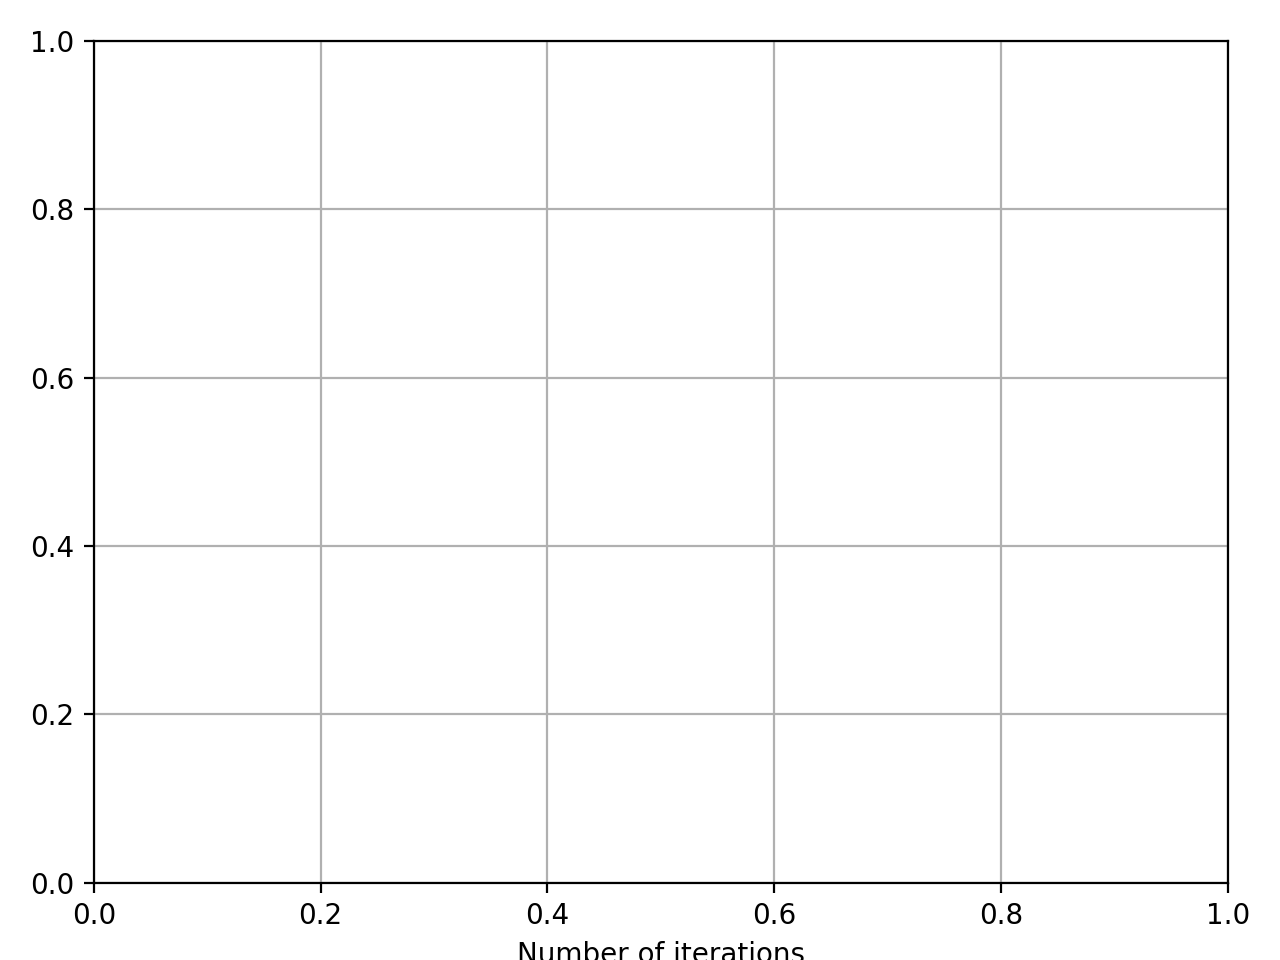

In [10]:
from noggin import create_plot
%matplotlib notebook
plotter, fig, ax = create_plot(metrics=["loss"], max_fraction_spent_plotting=.75)

In [11]:
from cogworks_data.language import get_data_path

from pathlib import Path
import json

# load COCO metadata
filename = get_data_path("captions_train2014.json")
with Path(filename).open() as f:
    coco_data = json.load(f)
    
#set(resnet18_features) < set(img["id"] for img in coco_data["images"])

#randomly shuffle?
split = int(82612*.8)

training = list(set(img["image_id"] for img in coco_data["annotations"]))[:split]
validation = list(set(img["image_id"] for img in coco_data["annotations"]))[split:]


In [12]:
from cogworks_data.language import get_data_path
from pathlib import Path
import json
from collections import defaultdict
!pip install image_search
import image_search


  Using cached argparse-1.4.0-py2.py3-none-any.whl.metadata (2.8 kB)
Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


In [13]:
class COCODataOrganizer:
    def __init__(self, name):
        filename = get_data_path(name)
    
        with Path(filename).open() as f:
            captions_train = json.load(f)

        image2url = {image["id"]: image["coco_url"] for image in captions_train["images"]}
    
        image2captions = defaultdict(list)
        for a in captions_train["annotations"]:
            image2captions[a["image_id"]].append(a["id"])
    
        self.caption2text = {a['id']: a['caption'] for a in captions_train['annotations']}
        #self.descriptors = {descriptors['id']: descriptors
    
        image_id = captions_train['images'][0]['id']
        image_url = image2url[image_id]

    def get_caption(self, image_id):
        #print(self.caption2text)
        return self.caption2text.get(image_id)

database = COCODataOrganizer("captions_train2014.json")

#print(database.get_caption(57870))

In [14]:
print(coco_data.keys())
print(coco_data["images"][0])


dict_keys(['info', 'images', 'licenses', 'annotations'])
{'license': 5, 'file_name': 'COCO_train2014_000000057870.jpg', 'coco_url': 'http://images.cocodataset.org/train2014/COCO_train2014_000000057870.jpg', 'height': 480, 'width': 640, 'date_captured': '2013-11-14 16:28:13', 'flickr_url': 'http://farm4.staticflickr.com/3153/2970773875_164f0c0b83_z.jpg', 'id': 57870}


In [15]:
train = []
skipped = []
descriptors1 = []
descriptors2 = []
captions = []
import random

for id in training: 
     
    confusor_image = None
    
    while confusor_image is None:
        try:
            confusor_image = resnet18_features[training[random.randrange(split - 1)]]
        except:
            continue
    
    try:
        if resnet18_features[id] is None:
            continue
        else:
            #database.get_caption(id)
            train.append([final_embeddings.get(id), resnet18_features[id], confusor_image])
            descriptors1.append(resnet18_features[id])
            descriptors2.append(confusor_image)
            captions.append(final_embeddings.get(id))

            if resnet18_features[id].shape != (1,512):
                print(id)
            if confusor_image.shape != (1,512):
                print(confusor_image)
   
    except:
        skipped.append(id)

print(len(skipped))
print(len(train))
train = np.asarray(train, dtype = "object")

#print(train[0])

133
65956


In [16]:
print(database.get_caption(7975))
#print(np.array(train[65954]).shape)

Food is sitting out on a counter or table.


<IPython.core.display.Javascript object>


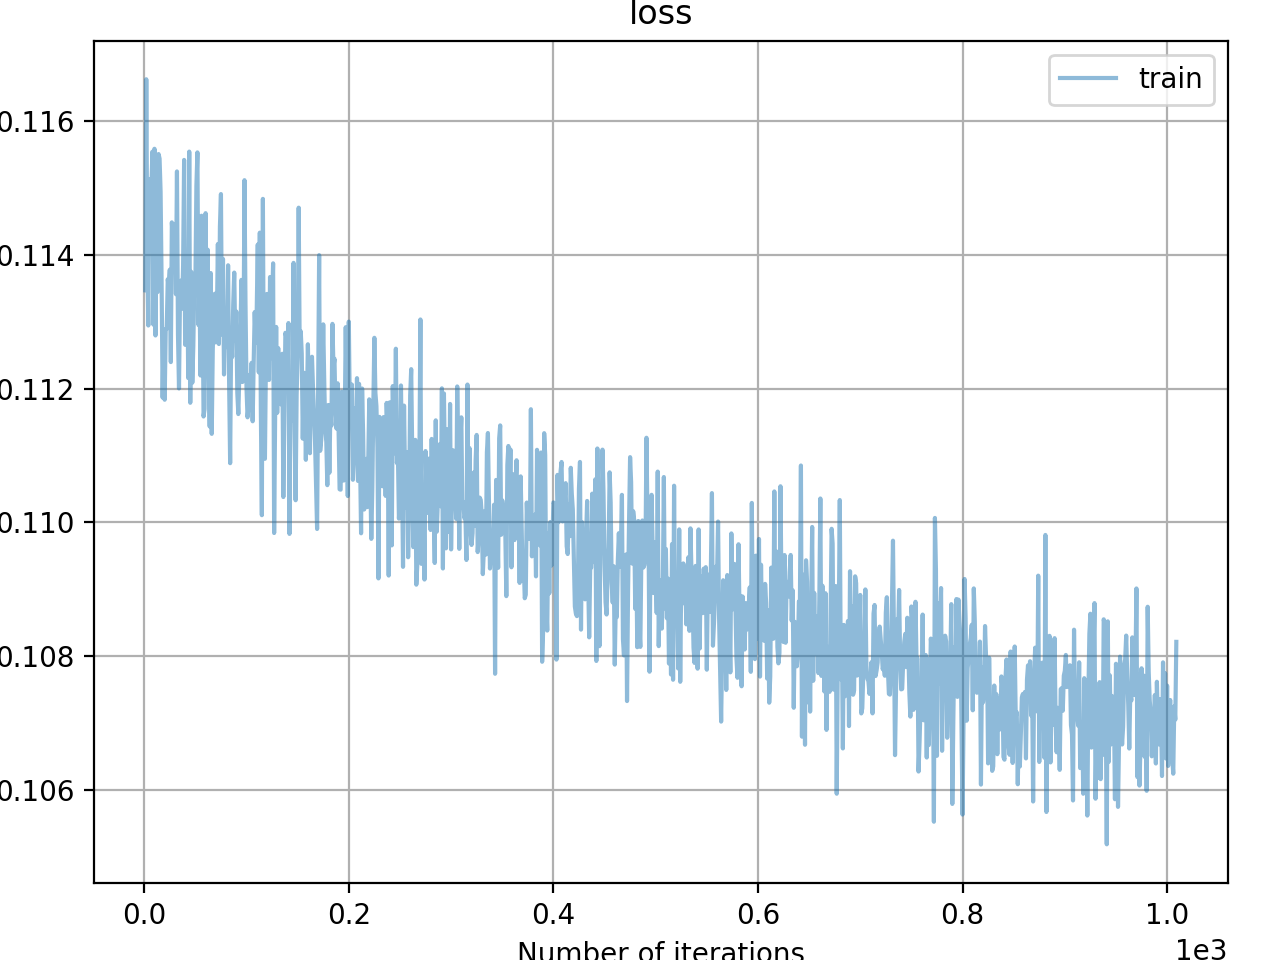

In [17]:
%matplotlib notebook
from noggin import create_plot
plotter, fig, ax = create_plot(metrics=["loss"])


In [ ]:
# STUDENT CODE HERE
import mygrad as mg

model = Model()

#descriptors1 = train[:, 1]
#print(descriptors1.shape)

#descriptors2 = train[:, 2]
#captions = train[:, 0]

optim = SGD(model.parameters, learning_rate=0.1, momentum=0.9)  # 
batch_size = 32
#65955

for epoch_cnt in range(1):
    idxs = np.arange(65955) 
    np.random.shuffle(idxs)  
    
    for batch_cnt in range(0, 65955//batch_size):
        batch_indices = idxs[batch_cnt*batch_size : (batch_cnt + 1)*batch_size]
        #print(batch_indices)
        batch = np.asarray(descriptors1)[batch_indices.astype(int)]  # random batch of our training data
        #print(batch.shape)
        # `model.__call__ is responsible for performing the "forward-pass"
        prediction = model(batch) 
        
        #loss = margin_ranking_loss(descriptors1[batch_indices[0]], descriptors2[batch_indices[0]], captions[batch_indices[0]], 0.1)
        loss = mg.mean(mg.maximum(0, 0.1 - np.asarray(captions)[batch_indices.astype(int)] * (prediction - model(np.asarray(descriptors2)[batch_indices.astype(int)]))))
        # you still must compute all the gradients!
        loss.backward()
        
        # the optimizer is responsible for updating all of the parameters
        optim.step()
        

        plotter.set_train_batch({"loss" : loss.item()},
                                 batch_size=batch_size)
plotter.plot()

In [19]:
"""
class image_database: 
    def __init__(self, file):
        self.images = {}
    
    def query(self, caption):
        weights = preprocess_captions([caption])
        embedding = embed_caption(weights, caption)

        dot_products = {}
        for id, img_embed in self.images:
            dot_products[embedding @ img_embed] = id 
        
"""
image_database = {}
for id in training:
    if resnet18_features[id] is None:
        continue
    descriptor = resnet18_features[id]
    database[id] = model(descriptor)
    
def query(caption_embedding, k=5):
    similarities = []
    for image_id, image_embedding in image_database.items():
        similarity_score = np.dot(caption_embedding, image_embedding)
        similarities.append((image_id, similarity_score))
    
    
    
    return similarities[:k]
    
#data = image_database("captions_train2014.json")     

NameError: name 'all_images' is not defined

In [ ]:
filename = get_data_path("captions_train2014.json")
with Path(filename).open() as f:
    captions_train = json.load(f)
# print(captions_train.keys())

#print(len(captions_train['images']))
#captions_train['images'][0]

### 4.2 Semantic Embedding

We will learn a mapping from the 512-dimensional image feature space to the common 50-dimensional semantic space of the following form:

&nbsp;&nbsp;&nbsp;&nbsp; `se_image(img_features) = img_features M + b`

where `M` is a parameter of shape `(512, 50)` and `b` is a parameter of shape `(1, 50)`.

### 4.3 Training

To find a good values for parameters `M` and `b`, we'll create a training set containing triples of the form: 

&nbsp;&nbsp;&nbsp;&nbsp; `(text, good_image, bad_image)`

We want the similarity in semantic space between `text` and `good_image` to be greater than the similarity between `text` and `bad_image`, i.e.,

&nbsp;&nbsp;&nbsp;&nbsp; `sim(se_text(text), se_image(good_image)) > sim(se_text(text), se_image(bad_image))`

To encourage this relationship to be true for a triple, we'll use a loss function called the "margin ranking loss" (e.g., `mygrad.nnet.margin_ranking_loss`). This loss penalizes when the ordering of the values is wrong, and stops penalizing once the order is right "enough" (determined by the desired margin). The reasoning is that once the ordering between values is right, we don't need to waste effort trying to make it even more right.

The margin ranking loss is defined as:

&nbsp;&nbsp;&nbsp;&nbsp; `loss(x1, x2, y, margin) = maximum(0, margin - y * (x1 - x2)))`

where `y = 1` means `x1` should be higher than `x2` and `y = 0` means `x2` should be ranked higher than `x1`.

If we let

&nbsp;&nbsp;&nbsp;&nbsp; `sim_to_good = sim(se_text(text), se_image(good_image))`

&nbsp;&nbsp;&nbsp;&nbsp; `sim_to_bad = sim(se_text(text), se_image(bad_image))`

then the loss for a single triple would be:

&nbsp;&nbsp;&nbsp;&nbsp; `loss(sim_to_good, sim_to_bad, 1, margin`)

### 4.4 Enhanced training set

Researchers have found that generating totally random triples for training doesn't usually result in the best performance. In the context of our image search project, notice that picking a random image and one of its captions for `text` and `good_image`, and then picking a totally random other image for `bad_image` will often result in an "easy" triple.

For example, `good_image` and `text` might be "a dog catching a frisbee", while `bad_image` is a picture of a pizza. During training, the model will learn to make these kinds of easy distinctions, but might not be able to make harder ones. For example, it might have trouble properly ranking images of dogs with frisbees verses dogs swimming (in response to queries like "dog with frisbee" or "dog in water") because somewhat similar images won't be generated too often when constructing the training set totally randomly.

Here's a simple approach for generating more "challenging" triples for the training set. Once a `good_image` and `text` (one of the good image's captions) are chosen, randomly sample a small set of potential bad images. Then pick the bad image that has a caption that's most similar to `text` (in terms of cosine similarity between the semantic embeddings of the captions). This should result in better query performance.

## 5 Dataset

We'll be using the Microsoft COCO dataset. From the website (http://cocodataset.org/):

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; "COCO is a large-scale object detection, segmentation, and captioning dataset."

The file `captions_train2014.json` contains all the COCO image metadata and annotations (captions) for the official training set from 2014.

Use `json.load()` to convert this file to a dictionary with keys:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; `['info', 'images', 'licenses', 'annotations']`

In [ ]:
from cogworks_data.language import get_data_path

from pathlib import Path
import json

# Load COCO metadata
filename = get_data_path("captions_train2014.json")
with Path(filename).open() as f:
    coco_data = json.load(f)

If you name the dictionary `captions_train`, then `captions_train['images']` is a list of length 82783, where each element is a dictionary containing metadata about an image. For example, `captions_train['images'][0]` looks like:


```python
{'license': 5,
 'file_name': 'COCO_train2014_000000057870.jpg',
 'coco_url': 'http://images.cocodataset.org/train2014/COCO_train2014_000000057870.jpg',
 'height': 480,
 'width': 640,
 'date_captured': '2013-11-14 16:28:13',
 'flickr_url': 'http://farm4.staticflickr.com/3153/2970773875_164f0c0b83_z.jpg',
 'id': 57870}
```

`captions_train['annotations']` is a list of length 414113, where each element is a dictionary related to a caption. For example, `captions_train['annotations'][0]` looks like:

```python
{'image_id': 318556,
 'id': 48,
 'caption': 'A very clean and well decorated empty bathroom'}
```

Some important notes:
- There are 5 captions per image.
- We used the `coco_url` to download the images to extract features from. You should also use the `coco_url` for exploring images and displaying search results.
- The keys (image ids) in `resnet18_features.pkl` correspond to the `id` property in the `captions_train['images'][i]` dictionaries.
- Some of the images only had 1 channel (grayscale), so we didn't extract image features from them. This means the dictionary in file `resnet18_features.pkl` has only 82612 keys (image ids) instead of the full 82783. You should treat the keys from `resnet18_features.pkl` as your set of image keys.

Tips:
- It might help keep things clear in your code to always use variables names for ids that describe what kind of id it is (e.g., `image_id` and `caption_id`).
- You might find it helpful to create additional dictionaries to make certain lookups easier (e.g., to get all captions for a particular image_id, to get the coco_url for a particular image_id, etc.).

## 6 Tasks for Team

These tasks are the minimum set of things that need to be completed as part of the capstone project. You should coordinate with your team about how to divide them up. (Note: Some might naturally be combined.)

* create capability to embed text (captions and queries)
* create training and validation sets of triples
* create function to compute loss, accuracy (in terms of triples correct)
* create MyNN model for embedding images
* train model
 * embed caption
 * embed good image
 * embed bad image
 * compute similarities from caption to good and caption to bad
 * compute loss with margin ranking loss
 * take optimization step
* create image "database" by mapping whole set of image features to semantic features with trained model
* create function to query database and return top k images
* create function to display set of images (given image ids)
 * note that the image metadata (contained in `captions_train2014.json`) includes a property called "coco_url" that can be used download a particular image on demand for display
 * maybe display their captions, too (for debugging)
* create function that finds top k similar images to a query image
 * maybe give option for doing similarity search in either semantic space or original image feature space

## 7 Optional Tasks

- make a simple website for your image search engine (with bottle or flask); more details to follow
- try alternative ways to embed text (e.g., remove stop words?, larger word embeddings?, other?)